In [648]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import hj_reachability as hj
from hj_reachability import sets

In [ ]:
"""
Receding Horizon Hamilton-Jacobi-Isaacs (RH-HJI) Reachability Framework
-------------------------------------------------------------------------

This notebook implements a receding horizon approach to Hamilton-Jacobi-Isaacs (HJI) reachability for real-time decision making and planning in dynamic environments. Traditional HJI reachability provides powerful safety and goal-reaching guarantees, but suffers from high computational costs when applied globally. This work addresses that limitation through local patch extraction and update mechanisms.

Key Features:
- Extracts local patches from a globally precomputed HJI value function.
- Efficiently updates these patches over a receding horizon using dynamic programming.
- Enables rapid adaptation to changes in goals, obstacles, or dynamics.

Future 
- Integrate with control strategies (e.g., MPPI) for practical, real-time applications.
- Visualizes evolving value functions and agent trajectories through interactive animations.

This framework is ideal for scenarios requiring real-time safety-aware navigation, such as robotics, autonomous driving, or dynamic task execution. It is built on top of the `hj_reachability` JAX library, ensuring high-performance GPU/TPU acceleration.

"""


In [ ]:




# --- Dynamics and Grid ---
class Unicycle(hj.ControlAndDisturbanceAffineDynamics):
    def __init__(self,
                 control_mode="min",
                 control_space=None):
        # State: [x, y, θ]
        # Control: [v, ω]  (linear velocity, angular velocity)

        if control_space is None:
            # Default control bounds: v ∈ [-1, 1], ω ∈ [-1, 1]
            control_space = sets.Box(
                jnp.array([-1.0, -1.0]),  # min values for v, ω
                jnp.array([1.0, 1.0])     # max values for v, ω
            )
        
        super().__init__(control_mode, control_space)

    def open_loop_dynamics(self, state, time):

        # No drift terms in unicycle model
        return jnp.zeros_like(state)

    def control_jacobian(self, state, time):
        x, y, theta = state

        # Jacobian of dynamics w.r.t. control [v, ω]
        return jnp.array([
            [jnp.cos(theta), 0.0],  # dx/dt
            [jnp.sin(theta), 0.0],  # dy/dt
            [0.0, 1.0],             # dθ/dt
        ])


In [651]:
# --- Grid initialization ---
dynamics = hj.systems.Air3d()
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    hj.sets.Box(lo=np.array([-5., -5., -np.pi]), hi=np.array([5., 5., np.pi])),
    (40, 40, 30),
    periodic_dims=2
)

# --- Signed distance for circles ---
def circle_sdf(grid, center, radius):
    coords = grid.states[..., :2]  # only x,y dims
    dist = 10 * (jnp.linalg.norm(coords - jnp.array(center), axis=-1) - radius)
    return dist

# --- Obstacles and Goal ---
obstacles = [
    {"center": [1.5, 1.0], "radius": 0.3},
    {"center": [-2.0, -1.5], "radius": 0.3},
    {"center": [1.5, -1.0], "radius": 0.5},
]

goal = {"center": [0.5, 0.0], "radius": 0.1}

# Initialize value function with goal region (negative inside goal)
goal_sdf = circle_sdf(grid, goal["center"], goal["radius"])
initial_values = jnp.ones(grid.shape)
initial_values = jnp.minimum(goal_sdf, initial_values)
for obs in obstacles:
    obs_sdf = circle_sdf(grid, obs["center"], obs["radius"])
    initial_values = jnp.maximum(obs_sdf, initial_values)
    

In [ ]:
# --- Global solve ---
times = jnp.linspace(0., -3.0, 61)
solver_settings = hj.SolverSettings.with_accuracy("high", hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)
all_values = hj.solve(solver_settings, dynamics, grid, times, initial_values)

# --- Patch Extraction ---
def extract_local_patch(grid, values, center_state, patch_shape):
    indices = [jnp.abs(g - s).argmin() for g, s in zip(grid.coordinate_vectors, center_state)]
    
    slices = [slice(max(0, int(i - p // 2)), int(i + p // 2 + 1)) for i, p in zip(indices, patch_shape)]

    local_vectors = [g[s] for g, s in zip(grid.coordinate_vectors, slices)]
    subgrid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
        hj.sets.Box(jnp.array([v[0] for v in local_vectors]), jnp.array([v[-1] for v in local_vectors])),
        tuple(len(v) for v in local_vectors),
        periodic_dims=2
    )
    sub_values = values[slices[0], slices[1], slices[2]]

    # For solving a circular patch
    # coords = subgrid.states[..., :2]  # only x,y
    # center_xy = jnp.array([center_state[0], center_state[1]])
    # dists = jnp.linalg.norm(coords - center_xy, axis=-1)
    # sub_values = jnp.where(dists <= 0.3, sub_values, 10)  # ∞: excluded from solve

    return subgrid, sub_values, slices

# --- Reintegrate Function ---
def reintegrate_patch(global_values, patch, slices):
    return global_values.at[slices[0], slices[1], slices[2]].set(patch)


100%|##########|  3.0000/3.0 [00:01<00:00,  1.66sim_s/s]


In [653]:
# --- Receding Horizon Loop ---
agent_state = jnp.array([2.0, 0.0, 0.0])
history = [agent_state.copy()]
values = all_values[-1]
values_hist = [values]

for t in range(10):
    subgrid, sub_values, slices = extract_local_patch(grid, values, agent_state, (21, 21, 15))
    local_times = jnp.linspace(0., -0.5, 11)
    updated_sub_values = hj.solve(solver_settings, dynamics, subgrid, local_times, sub_values)
    values = reintegrate_patch(values, updated_sub_values[-1], slices)
    values_hist.append(values)
    agent_state = agent_state.at[0].add(-0.2)
    history.append(agent_state.copy())


100%|##########|  0.5000/0.5 [00:00<00:00, 10.62sim_s/s]
100%|##########|  0.5000/0.5 [00:00<00:00, 10.74sim_s/s]
100%|##########|  0.5000/0.5 [00:00<00:00, 12.64sim_s/s]
100%|##########|  0.5000/0.5 [00:00<00:00, 12.70sim_s/s]
100%|##########|  0.5000/0.5 [00:00<00:00, 12.74sim_s/s]
100%|##########|  0.5000/0.5 [00:00<00:00, 12.82sim_s/s]
100%|##########|  0.5000/0.5 [00:00<00:00, 12.51sim_s/s]
100%|##########|  0.5000/0.5 [00:00<00:00, 12.59sim_s/s]
100%|##########|  0.5000/0.5 [00:00<00:00, 12.34sim_s/s]
100%|##########|  0.5000/0.5 [00:00<00:00, 12.59sim_s/s]


In [654]:
vmin, vmax = values.min(), values.max()
print(vmax, vmin)


92.524864 18.41192


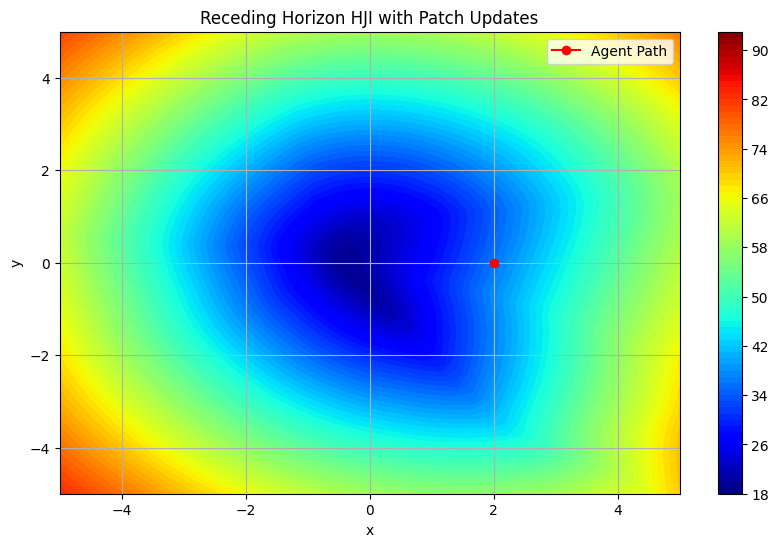

In [656]:
# --- Visualization and Animation ---
vmin, vmax = values.min(), values.max()
levels = jnp.linspace(round(vmin), round(vmax), round(vmax) - round(vmin) + 1)

fig, ax = plt.subplots(figsize=(10, 6))
history_np = np.stack(history)

# Obstacles and goal
circle_patches = []
for obs in obstacles:
    circle = plt.Circle(obs["center"], obs["radius"], color='red', alpha=0.4)
    ax.add_patch(circle)
    circle_patches.append(circle)

goal_circle = plt.Circle(goal["center"], goal["radius"], color='green', alpha=0.3)
ax.add_patch(goal_circle)

agent_dot, = ax.plot([], [], 'ro-', label='Agent Path')

ax.set_title("Receding Horizon HJI with Patch Updates")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True)
ax.legend()

# Initial plot to set colorbar
init_contour = ax.contourf(grid.coordinate_vectors[0],
                           grid.coordinate_vectors[1],
                           values_hist[-1][:, :, grid.shape[2] // 2].T, # get value of theta = 0 
                           levels=levels, cmap='jet')
fig.colorbar(init_contour)

contour_ref = [init_contour]

def animate(i):
    for coll in contour_ref[0].collections:
        coll.remove()
    contour = ax.contourf(grid.coordinate_vectors[0],
                          grid.coordinate_vectors[1], 
                          values_hist[i][:, :, grid.shape[2] // 2].T,
                          levels=levels, cmap='jet')
    contour_ref[0] = contour
    agent_dot.set_data(history_np[:i+1, 0], history_np[:i+1, 1])
    return contour.collections + [agent_dot]  + circle_patches + [goal_circle]

ani = animation.FuncAnimation(fig, animate, frames=len(values_hist), blit=True)
plt.show()

In [657]:
print(vmax)

92.524864


In [658]:
HTML(ani.to_jshtml())
